# Technical Challenge

Autoencoders in PyTorch - by Ruben Polak

---

## Introduction

In this notebook you will find three types of autoencoders. The first two are simple autoencoders, the second of which is a 'deep' extension to the first single-layered autoencoder. The third implementation is a variational autoencoder.

Cell by cell, this notebook is structured as follows:
- Load dependencies
- Data loading and pre-processing
- Autoencoder models and helper functions, where each class is an autoencoder type
- Training protocols, one for each autoencoder type
- Model building and training:
    - Instantiation + training of the simple autoencoder
    - Instantiation + training of the deep autoencoder
    - Instantiation + training of the variational autoencoder
- Results plotting functions for the autoencoder and deep autoencoder
- Latent space plotting function for the variational autoencoder
- Digit-generator function, where latent space samples can be decoded into figures

---
# Dependencies

The following libraries are required to run this contents of this notebook. If you do not have PyTorch installed, you can select the appropriate installation commands on the PyTorch website: http://pytorch.org/


In [1]:
from pandas import DataFrame
import pickle
import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn import functional
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [15,9]

---
# Data loading & preprocessing

Load the MNIST dataset from Torchvision and filter the dataset to only contain the digits 0, 1, 7, 3, 8 and 9. After we have loaded the normalized PIL images, we load the training dataset in a Torch DataLoader object. This object allows for easy batching and automatically shuffles the dataset after each epoch. We do the same for the test dataset; only here we do not need to enable the data shuffling.

In [2]:
# Prepare dataset:

# These are the digit requirements:
digits = [0,1,7,3,8,9]

# Function to transform the images into a PyTorch tensor:
transform = transforms.ToTensor()

# Get the normalized PIL images:
dataset = MNIST(root='./data', transform=transform, train=True, download=True)

# Filter for requirements:
dataset = [image for (image, target) in dataset if target in digits]

# Loader object to allow for batching and post-epoch shuffling.
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Finally do the same for the test data
test_set = MNIST(root='./data', transform=transform, train=False)
test_data = [image for (image, target) in test_set if target in digits]

targets = [target for (image, target) in test_set if target in digits]
dataloader_test = DataLoader(test_data, batch_size=batch_size, shuffle=False)

---
# Autoencoder models

Below are the three implementations of the autoencoder neural networks and - if required - their helper functions. Each network at least contains the following: The __init__ functions contain the initiation variables, which are the layer connections, dimensions and their activation functions. The __forward__ functions are called each time an input is passed into the network. The beauty of PyTorch is that you can very easily specify how you want your data to travel through the network.

In [3]:
input_dim = 784
encode_dim, decode_dim = 256, 256

class autoencoder(nn.Module):
    def __init__(self, latent_dim):
        
        super(autoencoder, self).__init__()
        
        # Linear in PyTorch is equivalent to Dense in Keras
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim),
            nn.ReLU(True))
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 784),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class deep_autoencoder(nn.Module):
    def __init__(self, latent_dim):
        
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, latent_dim),
            nn.ReLU(True))
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, input_dim),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
class variational_autoencoder(nn.Module):
    
    def __init__(self, latent_dim):
        
        super(variational_autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encode_dim),
            nn.ReLU(True))
            
        self.latent_mean = nn.Linear(encode_dim, latent_dim)
        
        self.latent_log_var = nn.Linear(encode_dim, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, decode_dim),
            nn.ReLU(True),
            nn.Linear(decode_dim, input_dim),
            nn.Sigmoid())
        
    def encode(self, image):
        x = self.encoder(image)
        lat_mean, lat_log_var = self.latent_mean(x), self.latent_log_var(x)
        return lat_mean, lat_log_var
        
        
    def reparameterize(self, z_mean, log_variance, batch_size):
        
        # std = exp(log_variance / 2)
        std = log_variance.mul(0.5).exp_()
        
        # Random normal vector depending on std size
        epsilon = torch.FloatTensor(std.size()).normal_()
        
        sample = z_mean + std * Variable(epsilon)
        return sample
    
    # This method either returns a latent representation for an image,
    # An image reconstruction based on an image, or
    # given any latent representation, a generated image.
    def forward(self, x, project=False):
        
        if len(x) is not 2:
            mean, log_variance = self.encode(x)
            latent = self.reparameterize(mean, log_variance, len(x))
            image = self.decoder(latent)
            
            if project is True:
                
                # Return the projection on the latent space
                return latent
            else:
                
                # Return the decoded representation given the image input
                return image, mean, log_variance
        else:
            
            # A latent vector has been fed into the network; return the decoded representation
            image = self.decoder(x)
            return image

# Loss function: not clear why my earlier implementations didn't work, this is an adaptation of:
# https://github.com/SherlockLiao/pytorch-beginner/blob/master/08-AutoEncoder/Variational_autoencoder.py
mse_loss = nn.MSELoss(size_average=False)
def vae_loss_function(batch, x, mean, log_variance):
    xent_loss = mse_loss(batch, x)
    kl_loss = torch.sum(mean.pow(2).add_(log_variance.exp()).mul_(-1).add_(1).add_(log_variance)).mul_(-0.5)
    loss = xent_loss + kl_loss

    return loss

# Helper function to pass test images through the networks
def get_images(test_data, sample_nr, model=None):
    
    images = []
    for i in range(sample_nr):
        
        if model is None:
            image = test_data[i]
            image = image.numpy()
            
            images.append(image)
            
        else:
        
            image = test_data[i]
            image = image.view(image.size(0), -1)
            image = Variable(image)

            output = model(image)
            output = output.data.numpy()

            images.append(output.reshape(28,28))
    
    return images

---
# Training protocols for the autoencoders

Here we specify the training protocols for each network. They are quite similar, and for each training we protocol we first instantiate the model, loss functions (criterions) and back propagate functions (optimizers). We then use a nested for-loop to train the model. The outer loop is the running epoch and the inner loop in a Pandas dataframe.

In [4]:
def train_simple(epochs, latent_dim, sample_nr):

    # Do some bookkeeping during training:
    recordings = {
                  "epoch" : [0],
                  "lt_dim" : [latent_dim],
                  "loss" : [0],
                  "test_imgs" : [get_images(test_data, sample_nr, model=None)]
                 }

    model = autoencoder(latent_dim)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    for epoch in range(epochs):

        for img in dataloader:
            img = img.view(img.size(0), -1)

            img = Variable(img)

            output = model(img)
            loss = criterion(output, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Finishing epoch {} of {}, loss at: {}'.format(epoch + 1, epochs, loss.data[0]))

        recordings['epoch'].append(epoch + 1)
        recordings['lt_dim'].append(latent_dim)
        recordings['loss'].append(loss.data[0])
        recordings['test_imgs'].append(get_images(test_data, sample_nr, model=model))

    df = DataFrame(data=recordings)
    
    return model, df

def train_deep(epochs, latent_dim, sample_nr):

    # Do some bookkeeping during training:
    recordings = {
                  "epoch" : [0],
                  "lt_dim" : [latent_dim],
                  "loss" : [0],
                  "test_imgs" : [get_images(test_data, sample_nr, model=None)]
                 }

    model = autoencoder(latent_dim)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    for epoch in range(epochs):

        for img in dataloader:
            img = img.view(img.size(0), -1)

            img = Variable(img)

            output = model(img)
            loss = criterion(output, img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Finishing epoch {} of {}, loss at: {}'.format(epoch + 1, epochs, loss.data[0]))

        recordings['epoch'].append(epoch + 1)
        recordings['lt_dim'].append(latent_dim)
        recordings['loss'].append(loss.data[0])
        recordings['test_imgs'].append(get_images(test_data, sample_nr, model=model))

    df = DataFrame(data=recordings)
    
    return model, df

def train_variational(epochs, latent_dim):
    
    # Bookkeeping:
    recordings = {
                  "epoch" : [0],
                  "lt_dim" : [latent_dim],
                  "loss" : [0],
                 }
    
    model = variational_autoencoder(latent_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    for epoch in range(epochs):
        for img in dataloader:
            img = img.view(img.size(0), -1)

            img = Variable(img)
            
            output, mean, log_variance = model(img)
            loss = vae_loss_function(output, img, mean, log_variance)
            
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            
        print('Finishing epoch {} of {}, loss at: {}'.format(epoch + 1, epochs, loss.data[0]))
    
        recordings['epoch'].append(epoch + 1)
        recordings['lt_dim'].append(latent_dim)
        recordings['loss'].append(loss.data[0])
    
    df = DataFrame(data=recordings)
    
    return model, df


---

# Training the autoencoders:

Train the autoencoder type by running the appropriate cell:

In [11]:
## SIMPLE AUTOENCODER

# Hyperparameters:
EPOCHS = 50
LATENT_DIM_1 = 16
LATENT_DIM_2 = 8
LATENT_DIM_3 = 32

# Sample numbers to store in the Pandas dataframe:
N_SAMPLES = 20

#simple_model_16, simple_results_16 = train_simple(EPOCHS, LATENT_DIM_1, N_SAMPLES)
#simple_model_8, simple_results_8 = train_simple(EPOCHS, LATENT_DIM_2, N_SAMPLES)
simple_model_32, simple_results_32 = train_simple(EPOCHS, LATENT_DIM_3, N_SAMPLES)

#image_set_simple_16 = simple_results_16['test_imgs']
#image_set_simple_8 = simple_results_8['test_imgs']
image_set_simple_32 = simple_results_32['test_imgs']

In [12]:
## DEEP AUTOENCODER

# Hyperparameters:
EPOCHS = 50
LATENT_DIM_1 = 16
LATENT_DIM_2 = 8
LATENT_DIM_3 = 32

# Sample numbers to store in the Pandas dataframe:
N_SAMPLES = 20

#deep_model_16, deep_results_16 = train_deep(EPOCHS, LATENT_DIM_1, N_SAMPLES)
#deep_model_8, deep_results_8 = train_deep(EPOCHS, LATENT_DIM_2, N_SAMPLES)
deep_model_32, deep_results_32 = train_deep(EPOCHS, LATENT_DIM_3, N_SAMPLES)

#image_set_deep_16 = deep_results_16['test_imgs']
#image_set_deep_8 = deep_results_8['test_imgs']
image_set_deep_32 = deep_results_32['test_imgs']

In [13]:
## VARIATIONAL AUTOENCODER

# Hyperparameters:
EPOCHS = 50
LATENT_DIM = 2

var_model, var_results = train_variational(EPOCHS, LATENT_DIM)

Finishing epoch 1 of 50, loss at: 7739.5751953125
Finishing epoch 2 of 50, loss at: 6353.40625
Finishing epoch 3 of 50, loss at: 6091.64697265625
Finishing epoch 4 of 50, loss at: 5339.74658203125
Finishing epoch 5 of 50, loss at: 5356.3642578125
Finishing epoch 6 of 50, loss at: 5186.9736328125
Finishing epoch 7 of 50, loss at: 4860.08349609375
Finishing epoch 8 of 50, loss at: 4967.3681640625
Finishing epoch 9 of 50, loss at: 4950.5859375
Finishing epoch 10 of 50, loss at: 5137.498046875
Finishing epoch 11 of 50, loss at: 4843.12158203125
Finishing epoch 12 of 50, loss at: 4718.380859375
Finishing epoch 13 of 50, loss at: 4602.7724609375
Finishing epoch 14 of 50, loss at: 4869.513671875
Finishing epoch 15 of 50, loss at: 4522.4140625
Finishing epoch 16 of 50, loss at: 4727.81640625
Finishing epoch 17 of 50, loss at: 4704.89501953125
Finishing epoch 18 of 50, loss at: 4722.5029296875
Finishing epoch 19 of 50, loss at: 4899.4072265625
Finishing epoch 20 of 50, loss at: 4857.47900390625

---

# Plotting simple and deep autoencoders outputs

Below is a cell where you can plot the outputs for a given training model at each epoch. The zero entry (__image_set_type_dim[0]__) is the test image input. 

It appears that the quality of decoded representations increase with an increased latent space. Generally, this is exactly what is expected when compressing data into a latent space and reconstructing the latent representation back into its original. 

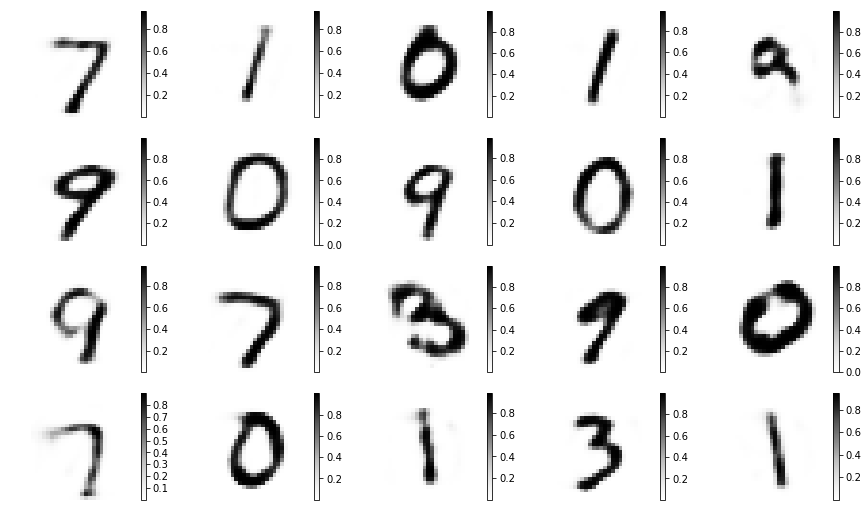

In [18]:
current_set = image_set_deep_32[50]
#current_set = image_set_simple_8[50]

size = len(current_set)
rows = 4
columns = size / rows

for idx, image in enumerate(current_set):
    
    plt.subplot(rows, columns, idx+1)
    plt.imshow(current_set[idx].reshape((28, 28)), interpolation='none', cmap='Greys')
    plt.colorbar()
    plt.axis('off')
    
plt.show()

---

# Plotting the VAE latent space

Below we plot the latent space of the variational autoencoder. Notice that all digits are clustered together, with similar digit shape cluster centroids being closer together. For instance, the "0" cluster is far away from the "1" cluster and the "3" cluster is close to the "8" cluster.

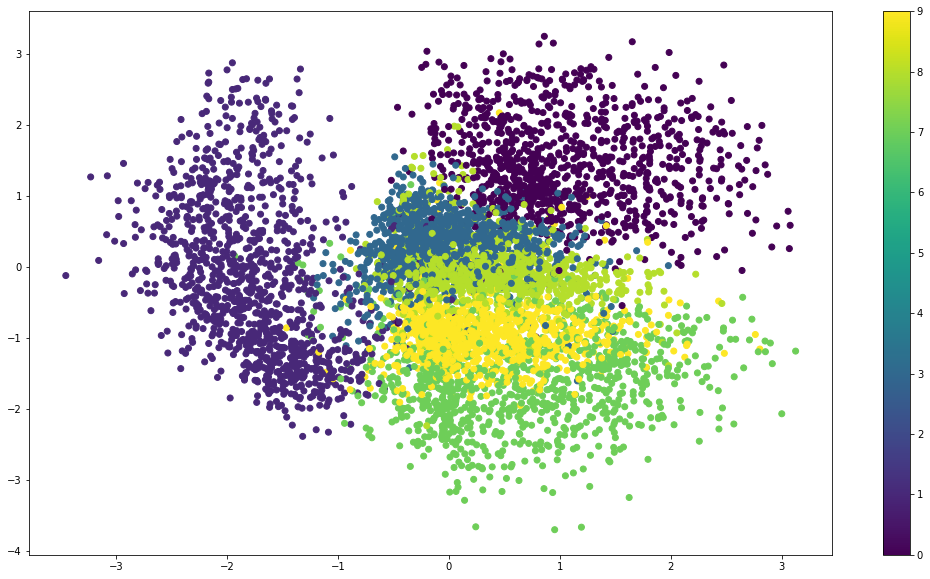

In [15]:
test_encoded = [var_model(Variable(img.view(img.size(0), -1)), project=True) 
                for img 
                in dataloader_test]
test_encoded = np.concatenate([batch.data.numpy() for batch in test_encoded])

plt.figure(figsize=(18, 10))
plt.scatter(test_encoded[:, 0], test_encoded[:, 1], c=targets)
plt.colorbar()
plt.show()


---

# Generating digits by sampling from the latent space

Here we sample coordinates in thea above plot, and feed them into the network to generate new digits. For instance, from the plot above we expect that feeding coordinate -0.8, 2 in the network will result in some combination of the digits 0 and 1. 



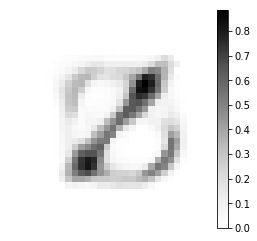

In [17]:
# Generate numbers using the following code:
coordinate = (-0.8, 2)

sample = Variable(torch.FloatTensor(list(coordinate)))

output = var_model(sample).data.numpy()

plt.figure(figsize=(4, 4))
plt.imshow(output.reshape(28,28), interpolation='none', cmap='Greys')
plt.colorbar()
plt.axis('off')
plt.show()